In [1]:
!pip install tensorflow==2.15.0
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install seaborn 
!pip install matplotlib
!pip install wordcloud
!pip install nltk

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     -------------------------------------- 269.5/269.5 kB 5.5 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autoviz 0.1.720 requires bokeh~=2.4.2, which is not installed.
autoviz 0.1.720 requires jupyter, which is not installed.
autoviz 0.1.720 requires panel>=0.12.6, which is not installed.
autoviz 0.1.720 requires statsmodels, which is not installed.


In [5]:
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
train_data = pd.read_csv("train.txt", header=None, sep=";", names=['Comment', 'Emotion'], encoding="utf-8")

In [8]:
train_data.head(5)

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [10]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [11]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [13]:
train_data['Comment'][99]

'i say goodbye to the fam theyre all sad a crying and i feel like a heartless bitch because hey im pretty excited to be flying for the first time and you know also to spend a year in another country'

In [14]:
train_data.shape

(16000, 3)

In [15]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [18]:
train_data['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [19]:
train_data.duplicated().sum()

1

In [21]:
train_data.drop_duplicates(inplace=True)

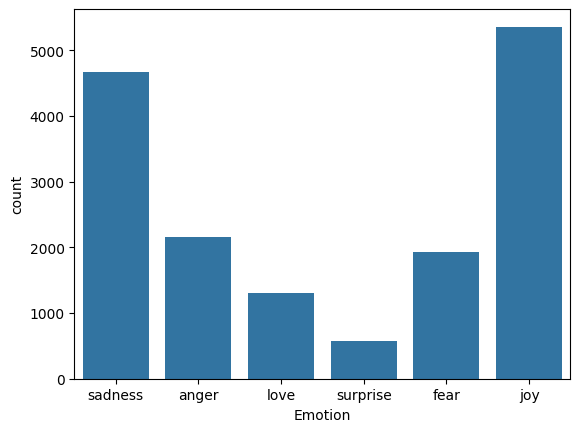

In [22]:
sns.countplot(x = train_data['Emotion'])
plt.show()

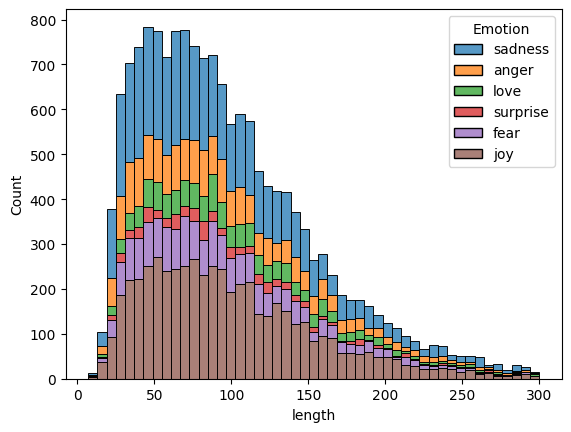

In [23]:
sns.histplot(data=train_data, x='length', hue='Emotion', multiple='stack')
plt.show()

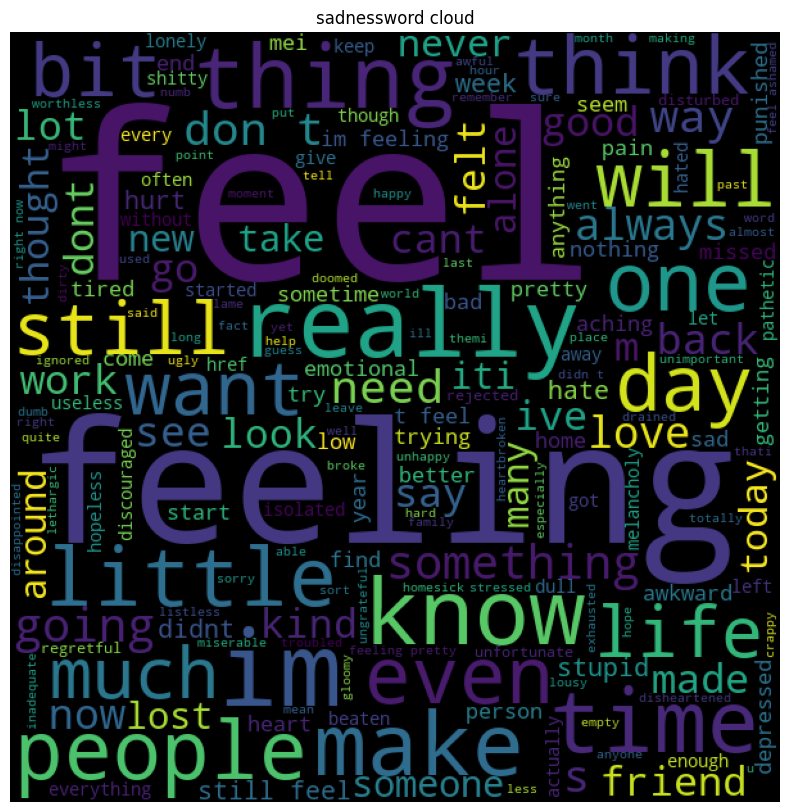

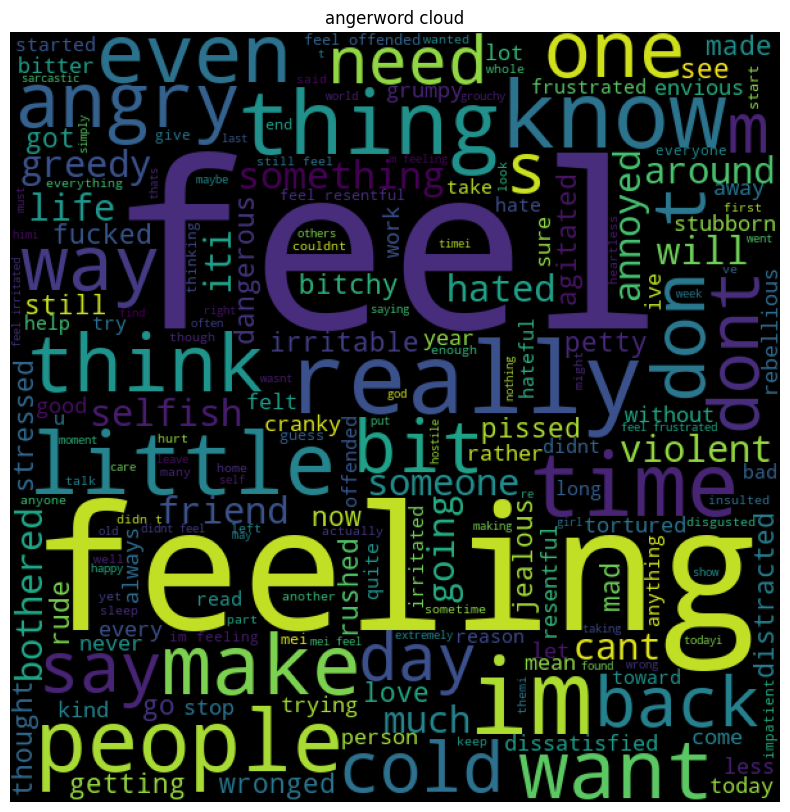

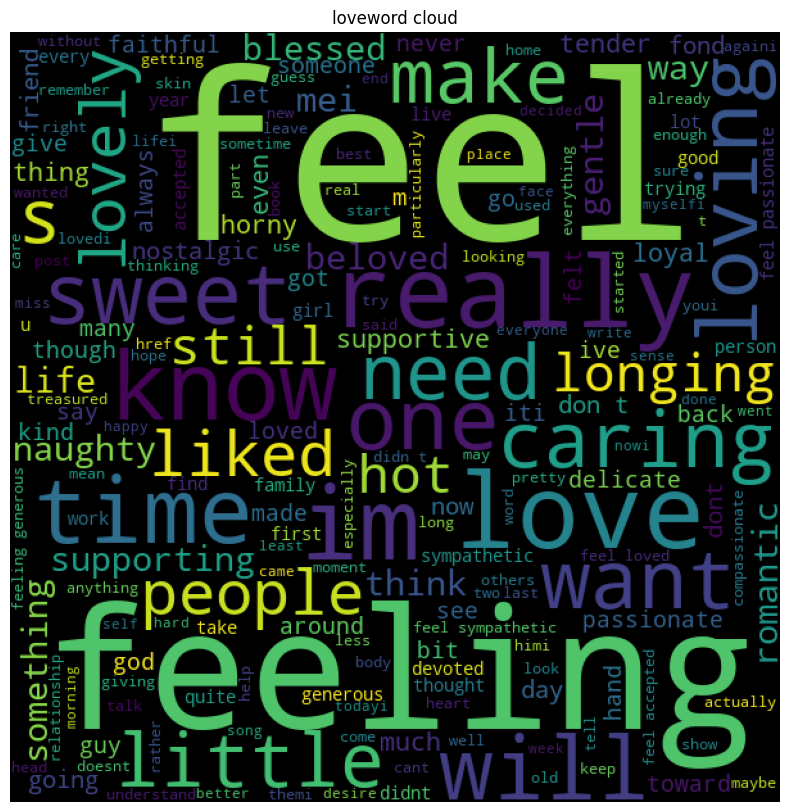

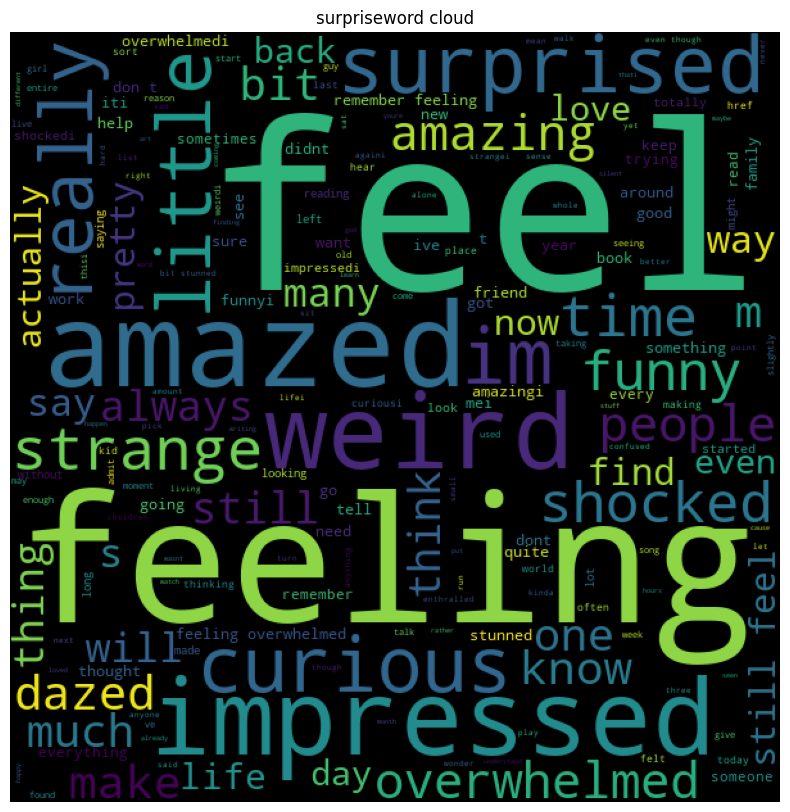

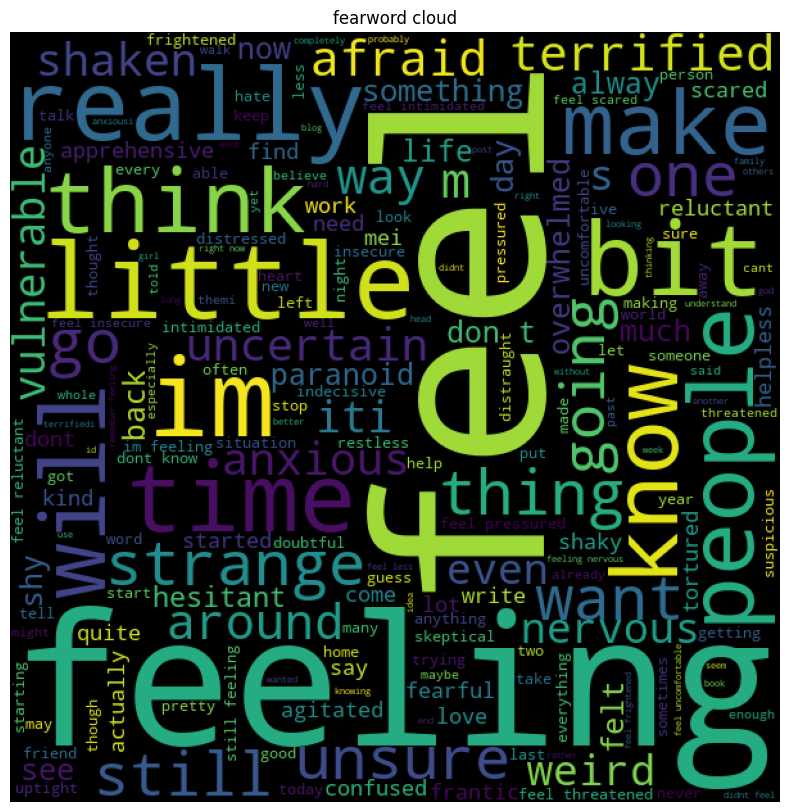

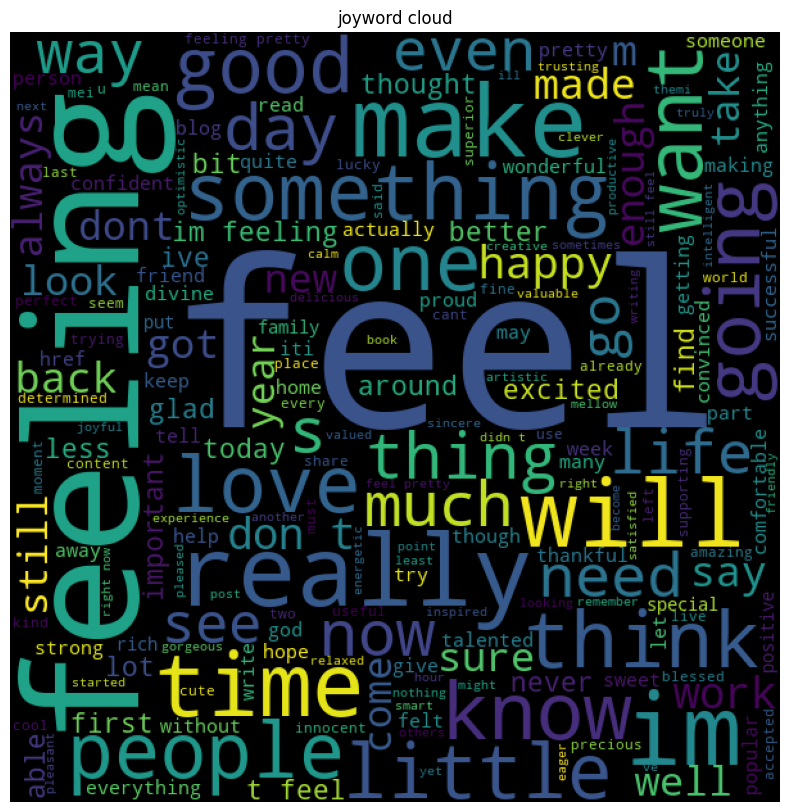

In [30]:
def words_cloud(wordcloud, emotion):
    plt.figure(figsize=(10, 10))
    plt.title(emotion + 'word cloud')
    plt.imshow(wordcloud)
    plt.axis("off")
emotion_list = train_data['Emotion'].unique()
for emotion in emotion_list:
    text = "".join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion, 'Comment']])
    wordcloud = WordCloud(width=600, height=600).generate(text)
    words_cloud(wordcloud, emotion)

In [31]:
lb = LabelEncoder()
train_data['Emotion_Encoded'] = lb.fit_transform(train_data['Emotion'])


In [32]:
train_data

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [35]:
df = train_data.copy()

In [36]:
df

,Comment,Emotion,length,Emotion_Encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [37]:
stopwords = set(nltk.corpus.stopwords.words('english'))


In [41]:
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

In [43]:
df['Cleaned_comment'] = df['Comment'].apply(clean_text)

In [46]:
df

,Comment,Emotion,length,Emotion_Encoded,Cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi
...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,sadness,102,4,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,joy,30,2,feel strong good overal
15998,i feel like this was such a rude comment and i...,anger,59,0,feel like rude comment im glad


In [48]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_comment'], df['Emotion_Encoded'], test_size=0.2, random_state=42)

In [49]:
X_train

676      refer cours though cant help feel somehow iron...
14180           would feel awkward someon tell feel toward
7077     feel like probabl would like book littl bit si...
13004    ive slow take time listen child moment feel li...
10264                         feel vital rlsh gimmick need
                               ...                        
13418         love leav reader feel confus slightli deceiv
5390                                            feel delic
860                                start feel littl stress
15796      feel accept music critic reinforc concept music
7270             feel someon rude wrongli done someth lose
Name: Cleaned_comment, Length: 12799, dtype: object

In [53]:
tfidf_vectorizer = TfidfVectorizer()

In [75]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [77]:
X_train_tfidf.shape

(12799, 4656)

In [78]:
X_test_tfidf.shape

(3200, 4656)

In [79]:
y_train.shape

(12799,)

In [80]:
y_test.shape

(3200,)

In [81]:
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}
for name, clf in classifiers.items():
    print(f"\n==========={name}=====")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(accuracy_tfidf)
    print(classification_report(y_test, y_pred_tfidf))


===========Multinomial Naive Bayes=====
0.7015625
              precision    recall  f1-score   support

           0       0.90      0.47      0.62       439
           1       0.86      0.38      0.53       375
           2       0.62      0.97      0.76      1027
           3       0.88      0.10      0.18       303
           4       0.74      0.92      0.82       950
           5       0.67      0.02      0.04       106

    accuracy                           0.70      3200
   macro avg       0.78      0.48      0.49      3200
weighted avg       0.75      0.70      0.65      3200


===========Logistic Regression=====


C:\Users\madam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.82125
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       439
           1       0.84      0.73      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.83      0.42      0.56       303
           4       0.87      0.92      0.90       950
           5       0.74      0.43      0.55       106

    accuracy                           0.82      3200
   macro avg       0.82      0.70      0.74      3200
weighted avg       0.83      0.82      0.81      3200


===========Random Forest=====
0.8428125
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       439
           1       0.80      0.87      0.83       375
           2       0.82      0.90      0.86      1027
           3       0.84      0.55      0.67       303
           4       0.92      0.88      0.90       950
           5       0.68      0.71      0.69       106

    accuracy                

In [82]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
y_pred_lg = lg.predict(X_test_tfidf)

C:\Users\madam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
def prediction(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorized)[0])
    return predicted_emotion, label

sentences = ["i didnt feel humilated",
            "i feel strong and good overall",
             "this is outrageous, how can you talk like that?"]
for sent in sentences:
    print(sent)
    predict_emotion, label = prediction(sent)
    print(predict_emotion)
    print(label)

i didnt feel humilated
sadness
4
i feel strong and good overall
joy
2
this is outrageous, how can you talk like that?
anger
0


In [84]:
import pickle
pickle.dump(lg, open("logistic_regression.pkl", 'wb'))
pickle.dump(lb, open("label_encoder.pkl", 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", 'wb'))

In [85]:
import sklearn
print(sklearn.__version__)

1.3.2


In [89]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [103]:
def clean_text(df, column,vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(w) for w in text if w not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding="pre")
    return pad
        
x_train = clean_text(train_data,'Comment', vocab_size=11000, max_len=300)

In [104]:
x_train

array([[   0,    0,    0, ..., 8924, 8268, 6705],
       [   0,    0,    0, ..., 4086, 5425, 5697],
       [   0,    0,    0, ..., 8268, 9279,  752],
       ...,
       [   0,    0,    0, ..., 4657, 7046, 1027],
       [   0,    0,    0, ..., 6866, 7025, 7880],
       [   0,    0,    0, ..., 8268,  905, 2465]])

In [105]:
x_train.shape

(15999, 300)

In [97]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])


In [99]:
y_train = to_categorical(train_data['Emotion'])

In [107]:
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=64, verbose=1)


Epoch 1/5


250/250 [==============================] - 185s 724ms/step - loss: 1.4356 - accuracy: 0.4268
Epoch 2/5
250/250 [==============================] - 162s 649ms/step - loss: 0.5532 - accuracy: 0.8139
Epoch 3/5
250/250 [==============================] - 148s 593ms/step - loss: 0.2678 - accuracy: 0.9122
Epoch 4/5
250/250 [==============================] - 148s 590ms/step - loss: 0.1865 - accuracy: 0.9379
Epoch 5/5
250/250 [==============================] - 144s 576ms/step - loss: 0.1458 - accuracy: 0.9487


In [109]:
def pred(text):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(w) for w in text if w not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad
    


sentences = [
    'I hate mangoes',
    'I feel strong and good overall',
    'He is really sweet and caring',
]
for sent in sentences:
    clean_sent = pred(sent)
    emotion = lb.inverse_transform(np.argmax(model.predict(clean_sent), axis=-1))[0]
    label = np.max(model.predict(clean_sent))
    print(emotion)
    print(label)
    print("====================")
    

1/1 [==============================] - 0s 30ms/step
anger
0.73148805
1/1 [==============================] - 0s 31ms/step
joy
0.99815625
1/1 [==============================] - 0s 41ms/step
love
0.7667536


In [110]:
model.save('model.h5')

C:\Users\madam\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
